# Practical 2

# Task 1: The Data

We use the mouse protein expression dataset: https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

Please use the dataset loading code provided below.

**Tasks 1.1: Dataset Exploration**
- How many samples / features are provided?
- How many labels does the dataset have?
- What is the value range of the predictors?
- Visualize the 10 first samples of the dataset
- Visualize the variance of each predictor.


In [12]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import os
print(pd.__version__)
print(os.getcwd())

file = 'data/Data_Cortex_Nuclear.csv'
df = pd.read_csv(file)
print(df.shape)
print("")

N = 10  # use only every tenth sample
X_all = df.iloc[::N,1:65].to_numpy()
t_all = (df['Behavior'] == 'S/C').to_numpy()[::N]

idx = ~np.any(np.isnan(X_all), axis=1)
X_all = X_all[idx]
t_all = t_all[idx]

1.0.1
E:\tmp\ml\Practical 2
(1080, 82)



In [13]:
# Value range
min = 1000
max = -1000
for x in X_all:
    m_min = 1000
    m_max = -1000
    for y in x:
        if y < m_min:
            m_min = y
        if y > m_max:
            m_max = y
    
    if m_min < min:
        min = m_min
    if m_max > max:
        max = m_max
print("Min: ", min, " Max: ", max)
print(X_all.shape)

Min:  0.06067111099999999  Max:  7.4640702139999995
(105, 64)


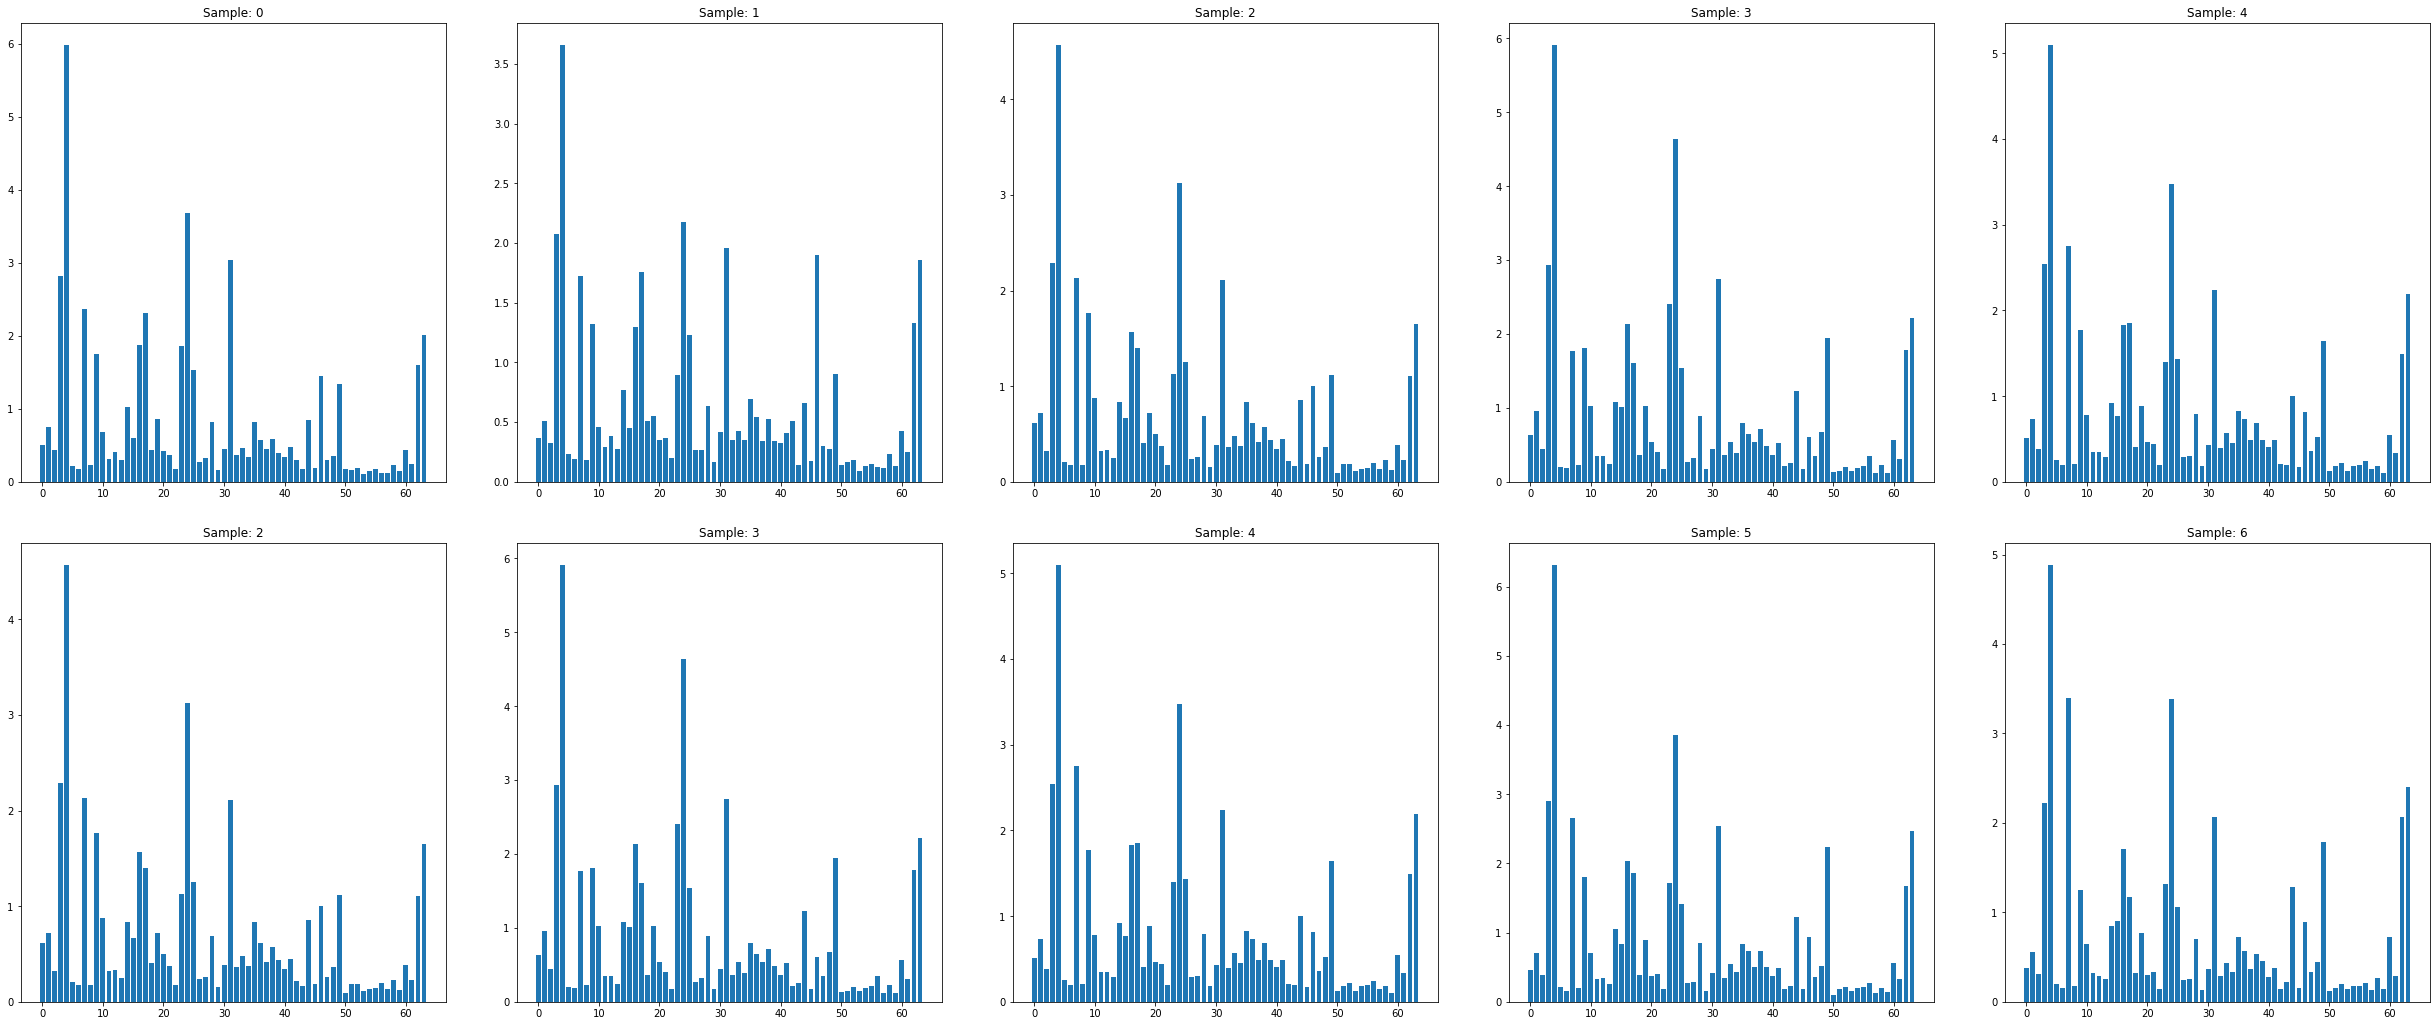

In [14]:
# Visualization of samples
fig, ax = plt.subplots(2, 5, figsize=(35, 15))
fig.tight_layout(pad=4.0)
for y in range(2):
    for x in range(5):
        el = X_all[y*2 + x]
        ax[y, x].bar(range(len(el)), el)
        ax[y, x].set_title("Sample: " + str(y*2 + x))

Text(0.5, 1.0, 'Variances of different predictors')

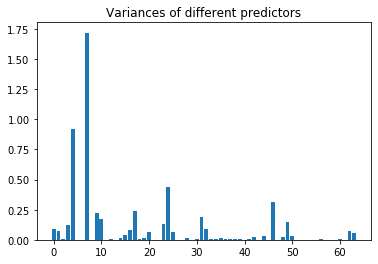

In [15]:
# Visualization of the variance of the predictors
plt.bar(range(len(X_all[0])), [np.var(X_all[:,i]) for i in range(len(X_all[0]))])
plt.title("Variances of different predictors")

**Task 1.1 - Answers**:
- The dataset provides 1080 samples, with 77 features (protein modifications)

- The dataset has 2 different labels: CS and SC

- The minimum of the values of the predictors is usually around ~0.1 while the maximum of those values differs a lot more and is around ~2-8 depending on the predictor. Therefore the general value range is probably (0-8).


**Task 1.2: Data Preprocessing**:  
- Write a function `split_data(X, y, frac, max_samples, seed)` that first shuffles your training data and then splits it into a training and a test set. `frac` determines the relative size of the test dataset, `seed` makes sure we get reproducible 
results.  
- Write a function `preprocess(X, y)` which zero-centers your data and sets variance to one.

In [16]:
import copy

def split_data(X, y, frac=0.3, max_samples=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Make copies of the dataset
    _X = copy.deepcopy(X)
    _y = copy.deepcopy(y)        
        
    random_state = np.random.get_state()
    np.random.shuffle(_X)
    np.random.set_state(random_state)
    np.random.shuffle(_y)
    
    N = math.floor(len(_X) * frac)
    X_test = _X[:N]
    X_train = _X[N:]
    
    y_test = _y[:N]
    y_train = _y[N:]
    
    return X_train, X_test, y_train, y_test

def preprocess(X, y):
    # Zero centering: setting the mean of each column to zero, means: subtracting the column-mean from each element
    # (assuming each column seperately)
    X = X - X.mean(axis=0)
    #y = y - y.mean(axis=0)
    
    # Set the variance to one, means: dividing each element by the column-standard-deviation
    # (assuming each column seperately)
    X = X / X.std()
    #y = y / y.std()
    
    return X, y

# Task 2: LDA

First, use Linear Discriminant Analysis to separate the classes. As discussed in the Bishop in pg. 186-189, we can find a weight vector $\vec{w}$ that performs a projection of the i-th input data point $\vec{x}_i$

$p =   \vec{w}^T \vec{x}_i$

that optimally separates the classes.

Use the analytic solution to compute the optimal weights $\vec{w}$ from the training set data. 

**Task 2.1**

1. Implement a function `compute_lda_weights(x, y)`, which carries out LDA using the data `x,y`. 
2. Apply this function on your training data.
3. Visualize the obtained weight vector $\vec{w}$ using a `plt.stemplot`.

In [17]:
def compute_lda_weights(x, y):
    
    # Preprocessing
    #x, y = preprocess(x, y)
    
    # Split dataset into 2 classes
    c1, c2 = [], []
    for i in range(len(x)):
        if(y[i]):
            c1.append(x[i])
        else:
            c2.append(x[i])
            
    c1 = np.array(c1)
    c2 = np.array(c2)
            
    # Calculate means:   
    tmp = np.zeros((64,))
    for c in c1:
        tmp = tmp + c[:, None]
    tmp = tmp / len(c1)
    
    m1 = np.mean(c1, axis=0)[:, None]
    m2 = np.mean(c2, axis=0)[:, None]
    mdiff = m2 - m1
        
    # Calculate within-class variance and its inverse    
    s_w = np.zeros((1,64))
    for n in c1:
        n = n[:, None]
        s_w = s_w + np.dot((n - m1), (n - m1).T)
        
    for n in c2:
        n = n[:, None]
        s_w = s_w + np.dot((n - m2), (n - m2).T)
        
    inv_s_w = np.linalg.inv(s_w)
    weights = np.dot(inv_s_w, mdiff)
    
    return m1, m2, mdiff, weights

Text(0.5, 0, 'predictors')

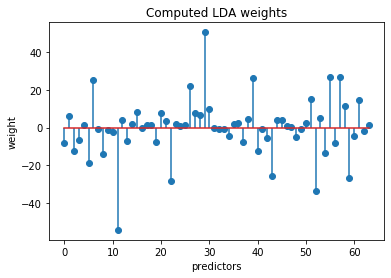

In [18]:
X, X_test, t, t_test = split_data(X_all, t_all, seed=1)
m0, m1, mdiff, w_lda = compute_lda_weights(X, t)

#w_lda = np.random.uniform(-1, 1, 50)  # example data
plt.stem(w_lda.flatten(), use_line_collection=True)
plt.title('Computed LDA weights')
plt.ylabel('weight')
plt.xlabel('predictors')

**Task 2.3**

Project the training data and the test data on $\vec{w}$. Visualize the class separation using a two-color histogram. 
- Is the class separation good?
- Is there a big difference between training and test data?

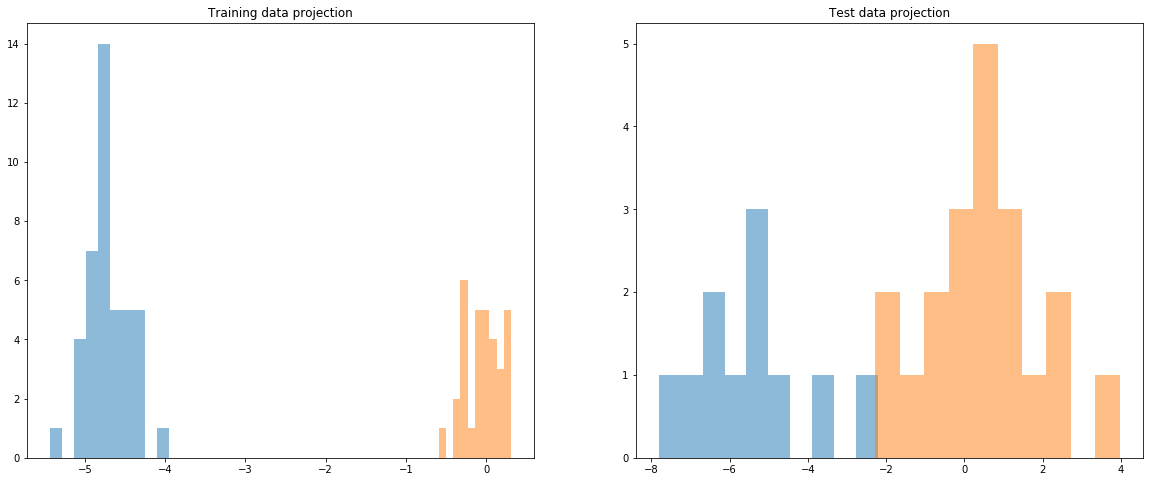

In [19]:
#a, b = np.random.normal(2, 1, 20), np.random.normal(0, 1, 20)  # example data
fig, ax = plt.subplots(1,2, figsize=(20,8))

# Training data
a, b = [], []
for i in range(len(X)):
    if(t[i]):
        a.append(np.dot(w_lda[:, 0].T, X[i]))
    else:
        b.append(np.dot(w_lda[:, 0].T, X[i]))

a = np.array(a)
b = np.array(b)

ax[0].set_title('Training data projection')
_ = ax[0].hist(a,label='class 0',alpha=0.5)
_ = ax[0].hist(b,label='class 1',alpha=0.5)


# Test data
a, b = [], []
for i in range(len(X_test)):
    if(t_test[i]):
        a.append(np.dot(w_lda[:, 0].T, X_test[i]))
    else:
        b.append(np.dot(w_lda[:, 0].T, X_test[i]))

a = np.array(a)
b = np.array(b)

ax[1].set_title('Test data projection')
_ = ax[1].hist(a,label='class 0',alpha=0.5)
_ = ax[1].hist(b,label='class 1',alpha=0.5)

**Answers for Task 2.3**
1. On the training data, the class seperation is very good, while on the test data the seperation is less good. Still, even on the test data, it is adequat.
2. The test data is much less well seperated than the training data. This is a hint for overfitting.

**Task 2.4**

Now we make class predictions based on the projections. Read https://en.wikipedia.org/wiki/Linear_discriminant_analysis#Fisher's_linear_discriminant and compute threshold $c$ for the projected values $p$ based on the training data. Print the value of $c$ and plot $c$ into the histograms of projected values you made before!

Use $c$ to assign class labels for training and test set. Determine the classification errors on both datasets and print them. 

-2.378379995868631
Classification errors on the training set: 0 errors on 74 elements
Classification errors on the test set: 1 errors on 31 elements


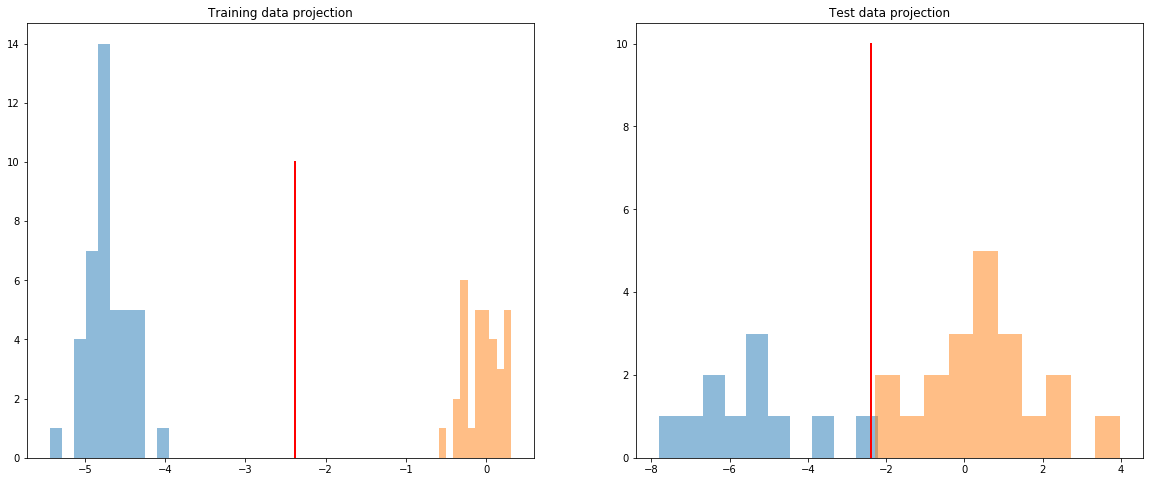

In [20]:
# Calculating the threshold
def calc_threshold(m0, m1, weights):
    c = np.dot(weights[:, 0], 0.5 * (m0 + m1)[:, 0])
    print(c)
    return c

def plot_histograms_with_c(c, w_lda, X, t, X_test, t_test):
    fig, ax = plt.subplots(1,2, figsize=(20,8))

    # Training data
    a, b = [], []
    for i in range(len(X)):
        if(t[i]):
            a.append(np.dot(w_lda[:, 0], X[i]))
        else:
            b.append(np.dot(w_lda[:, 0], X[i]))

    a = np.array(a)
    b = np.array(b)

    ax[0].set_title('Training data projection')
    _ = ax[0].hist(a,label='class 0',alpha=0.5)
    _ = ax[0].hist(b,label='class 1',alpha=0.5)
    _ = ax[0].plot([c, c], [0, 10], color='r', linestyle='-', linewidth=2)


    # Test data
    a, b = [], []
    for i in range(len(X_test)):
        if(t_test[i]):
            a.append(np.dot(w_lda[:, 0], X_test[i]))
        else:
            b.append(np.dot(w_lda[:, 0], X_test[i]))

    a = np.array(a)
    b = np.array(b)

    ax[1].set_title('Test data projection')
    _ = ax[1].hist(a,label='class 0',alpha=0.5)
    _ = ax[1].hist(b,label='class 1',alpha=0.5)
    _ = ax[1].plot([c, c], [0, 10], color='r', linestyle='-', linewidth=2)
    
    
def assign_labels_by_c(c, w_lda, X, X_test, t, t_test):
    
    errors = 0
    for i in range(len(X)):
        r = np.dot(w_lda[:, 0], X[i])
        label = r < c
        if label != t[i]:
            errors = errors +1
    
    errors_train = errors
    
    errors = 0
    for i in range(len(X_test)):
        r = np.dot(w_lda[:, 0], X_test[i])
        label = r < c
        if label != t_test[i]:
            errors = errors +1
    errors_test = errors
    
    return errors_train, errors_test

# Plot c into the histograms
c = calc_threshold(m0, m1, w_lda)
plot_histograms_with_c(c, w_lda, X, t, X_test, t_test)

# Use c to assign class labels and print the classification error
errors_train, errors_test = assign_labels_by_c(c, w_lda, X, X_test, t, t_test)
print("Classification errors on the training set: " + str(errors_train) + " errors on " + str(len(X)) + " elements")
print("Classification errors on the test set: " + str(errors_test) + " errors on " + str(len(X_test)) + " elements")


## Task 3: Logistic Regression

Next, we will consider classification using Logistic Regression. Below, you find all imports that are necessary.


In [21]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import copy

**Task 3.1: Iterative Reweighted Least Squares**

1. Implement the IRLS algorithm and output at each iteration the current training error. Remember the weight are updated according to:
$$ w' = w - ( \Phi^T R \Phi ) ^ {-1} \Phi^T (y - t)$$
Where $y$ is the prediction, $t$ the ground truth target, $R$ the weighting matrix and $\Phi$ the design matrix.
2. Apply the IRLS algorithm on data and compute a test error (see the code below).
3. Compare the results of your implementation to the sklearn implementation of `LogisticRegression(penalty='none')`. Do you get the same result?
4. Use the `preprocess` function defined earlier to normalize the data.

In [22]:
# Task 3.1 IRLS

def irls(X_all, t_all, do_preprocessing=True):

    # Generate new set of data
    X, X_test, t, t_test = split_data(X_all, t_all, seed=1)

    # Import for sigmoid
    from scipy.special import expit

    # Seed
    np.random.seed(1)

    # Preprocessing
    if do_preprocessing:
        _X, __t = preprocess(copy.deepcopy(X), copy.deepcopy(t))
    else:
        _X, __t = copy.deepcopy(X), copy.deepcopy(t)

    _t = np.zeros(__t.shape)
    for i in range(len(_t)):
        _t[i] = 1 if __t[i] else 0
    _t = _t[:, None]
    
    
    # Constants
    max_iter = 100
    weights = np.zeros((X_all.shape[1],1))

    # Initial prediction
    y = expit(np.dot(weights.T, _X.T))

    # Initial error
    mse = 10000

    for idx in range(max_iter):
    
        old_mse = mse
        old_w = weights
    
        # Calculate R matrix
        R = np.identity(y.size)
        for n in range(y.size):
            R[n, n] = y[0, n] * (1 - y[0, n])
    
        # Calculate new weights
        gradE = np.dot(_X.T, (y.T - _t))    
        hessian = np.dot(_X.T, np.dot(R, _X))    
        inv_hessian = np.linalg.inv(hessian)
    
        weights = weights - np.dot(inv_hessian, gradE)
    
    
        # Make new predictions
        y = expit(np.dot(weights.T, _X.T))
        #print("Y:", y)
        #print("T:", _t.T)
        #print("-:", (y - _t.T))
    
        # Calculate error
        mse = ((y - _t.T)**2).mean(axis=1)
        print("Training error after iteration " + str(idx) + ": " + str(mse))

        # Break if error does not decrease anymore
        if old_mse == mse or old_mse < mse:
            mse = old_mse
            weights = old_w
            break
        
    print("Final training set error: " + str(mse))


    # Compute error on test set

    # Preprocessing
    _X_test, __t_test = preprocess(X_test, t_test)

    _t_test = np.zeros(__t_test.shape)
    for i in range(len(_t_test)):
        _t_test[i] = 1 if __t_test[i] else 0
    _t_test = _t_test[:, None]

    # Prediction
    y = expit(np.dot(weights.T, _X_test.T))

    error = ((y - _t_test.T)**2).mean(axis=1)
    
    print("Final test set error: " + str(error))


    # Try on Sklearn's logistic regression
    _t = _t.flatten()
    clf = LogisticRegression(penalty='none').fit(_X, _t)
    sk_y = clf.predict(_X_test)

    sk_error = ((sk_y - _t_test.flatten())**2).mean(axis=0)

    print("SkLearn test set error: " + str(sk_error))
    
    return y, error

_, _ = irls(X_all, t_all)

Training error after iteration 0: [0.01847144]
Training error after iteration 1: [0.00286865]
Training error after iteration 2: [0.00045209]
Training error after iteration 3: [6.85937396e-05]
Training error after iteration 4: [9.98756668e-06]
Training error after iteration 5: [1.41237378e-06]
Training error after iteration 6: [1.96631769e-07]
Training error after iteration 7: [2.70462491e-08]
Training error after iteration 8: [3.6804034e-09]
Training error after iteration 9: [4.98906764e-10]
Training error after iteration 10: [6.76055846e-11]
Training error after iteration 11: [9.16063197e-12]
Training error after iteration 12: [1.24124494e-12]
Training error after iteration 13: [1.68179888e-13]
Training error after iteration 14: [2.27862118e-14]
Training error after iteration 15: [3.08711356e-15]
Training error after iteration 16: [4.18233548e-16]
Training error after iteration 17: [5.66598804e-17]
Training error after iteration 18: [7.67588368e-18]
Training error after iteration 19: 

**Answers: Task 3.1**
1. Between our own implementation of IRLS and SkLearn's version, we get a similar error on the test set, our implementation has ~0.14 and SkLearn has ~0.09.


**Task 3.2: Logistic Regression with Regularization**

1. Set sklearn's penalty parameter to `l1` and `l2`. Use the range `np.linspace(0.02, 1, 25)` for the parameter `C`, which controls the strength of regularization.
2. Plot strength of regularization over accuracy. Does regularization improve the scores?
3. Visualize the coefficients of the regularized settings and the unregularized setting. What do you observe?
3. Compare the coefficients to the LDA weights.

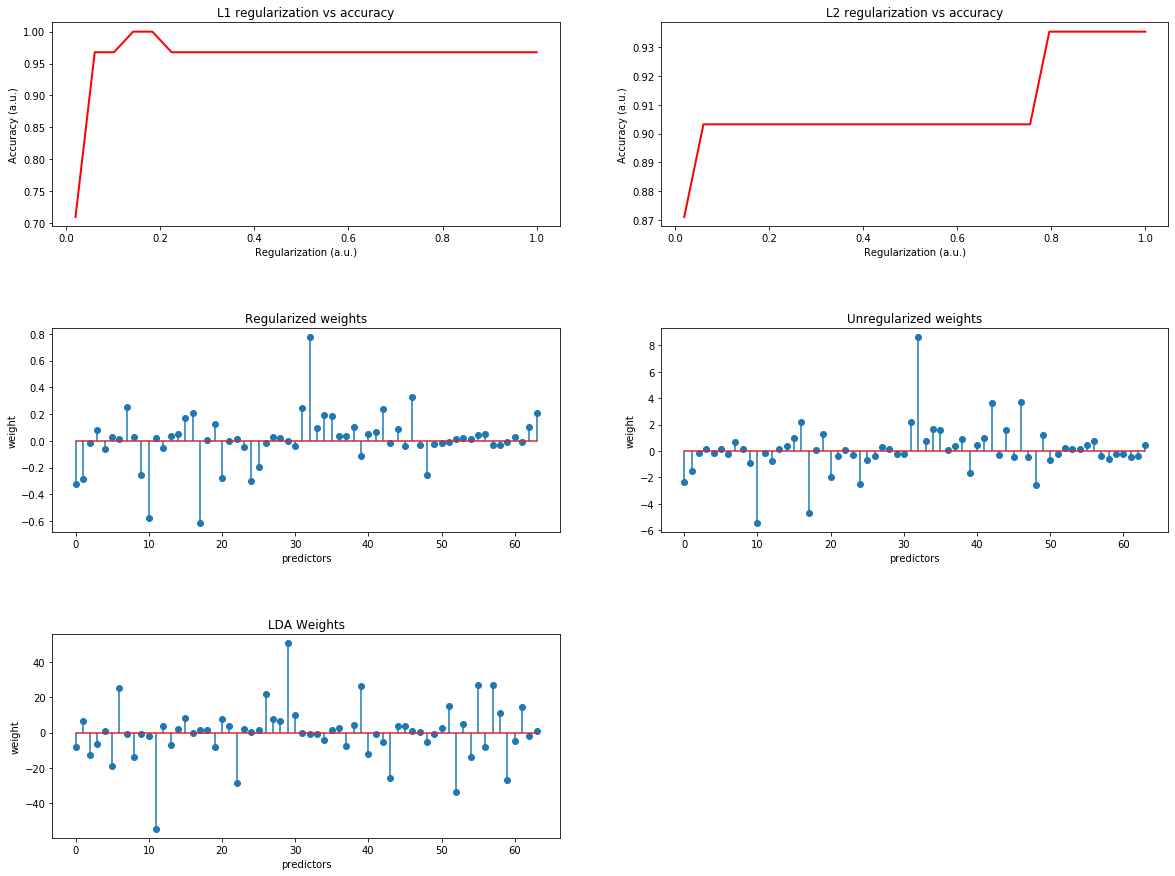

In [23]:
from matplotlib import pyplot as plt

cs = np.linspace(0.02, 1, 25)
fig, ax = plt.subplots(3,2, figsize=(20,15))
fig.subplots_adjust(hspace=0.5)

# New dataset
X, X_test, t, t_test = split_data(X_all, t_all, seed=1)

# Preprocessing
_X, __t = preprocess(X, t)

_t = np.zeros(__t.shape)
for i in range(len(_t)):
    _t[i] = 1 if __t[i] else 0
_t = _t[:, None]


_X_test, __t_test = preprocess(X_test, t_test)

_t_test = np.zeros(__t_test.shape)
for i in range(len(_t_test)):
    _t_test[i] = 1 if __t_test[i] else 0
_t_test = _t_test[:, None]
_t = _t.flatten()


# L1 regularization
acc_l1 = np.zeros(len(cs))
for i in range(len(cs)):
    
    c = cs[i]
    clf = LogisticRegression(solver="liblinear", penalty='l1', C=c).fit(_X, _t)
    acc_l1[i] = clf.score(_X_test, _t_test)
    
    
ax[0, 0].set_title('L1 regularization vs accuracy')
_ = ax[0, 0].plot(cs, acc_l1, color='r', linestyle='-', linewidth=2)
_ = ax[0, 0].set_xlabel("Regularization (a.u.)")
_ = ax[0, 0].set_ylabel("Accuracy (a.u.)")


# L2 regularization
acc_l2 = np.zeros(len(cs))
for i in range(len(cs)):
    
    c = cs[i]
    clf = LogisticRegression(solver="liblinear", penalty='l2', C=c).fit(_X, _t)
    acc_l2[i] = clf.score(_X_test, _t_test)
    
    
ax[0, 1].set_title('L2 regularization vs accuracy')
_ = ax[0, 1].plot(cs, acc_l2, color='r', linestyle='-', linewidth=2)
_ = ax[0, 1].set_xlabel("Regularization (a.u.)")
_ = ax[0, 1].set_ylabel("Accuracy (a.u.)")


# Visualize regularized vs unregularized weights

# Regularized
clf = LogisticRegression(solver="liblinear", penalty='l2', C=cs[6]).fit(_X, _t)

ax[1, 0].set_title("Regularized weights")
ax[1, 0].stem(clf.coef_[0, :], use_line_collection=True)
ax[1, 0].set_ylabel('weight')
ax[1, 0].set_xlabel('predictors')


# Unregularized
clf = LogisticRegression(penalty='none').fit(_X, _t)

ax[1, 1].set_title("Unregularized weights")
ax[1, 1].stem(clf.coef_[0, :], use_line_collection=True)
ax[1, 1].set_ylabel('weight')
ax[1, 1].set_xlabel('predictors')


# Compare to LDA weights
ax[2, 0].set_title("LDA Weights")
ax[2, 0].stem(w_lda, use_line_collection=True)
ax[2, 0].set_ylabel('weight')
ax[2, 0].set_xlabel('predictors')


# Delete last plot
ax[2, 1].set_visible(False)
    

**Answers: Task 3.2**
1: The regularization vs accuracy plots show that regularization does improve accuracy, with L1, even very little regularization does greatly improve accuracy and on L2 the accuracy improves best if the regularization is high.

2: Between the regularized weights and the unregularized weights, we see that regularized weights are a lot smaller than unregularized weights, which are in turn even smaller than LDA weights.



### Task 3.3: Arryhtymia and Ionosphere Dataset

Next, let's run your code on the datasets from openml below.

1. First, explore the dataset. Which differences to ionosphere do you encounter?   
2. Run your IRLS implementation on unprocessed data and preprocessed data. Does it work? If not, why?
3. Compare with sklearn Logistic Regression.

(452, 25)
(351, 34)
Arr: Min:  -179.0  Max:  780.0
(452, 25)
Ion: Min:  -1.0  Max:  1.0
(351, 34)
Error occured during processing of Arryhtymia unprocessed.
Error occured during processing of Arryhtymia unprocessed.
Error occured during processing of Ionosphere unprocessed.
Error occured during processing of Ionosphere unprocessed.
SkLearns score on arryhtmyia (unprocessed):  0.6518518518518519
SkLearns score on arryhtmyia (preprocessed):  0.6370370370370371
SkLearns score on ionosphere (unprocessed):  0.9142857142857143
SkLearns score on ionosphere (preprocessed): 0.8952380952380953


E:\data\program\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
E:\data\program\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

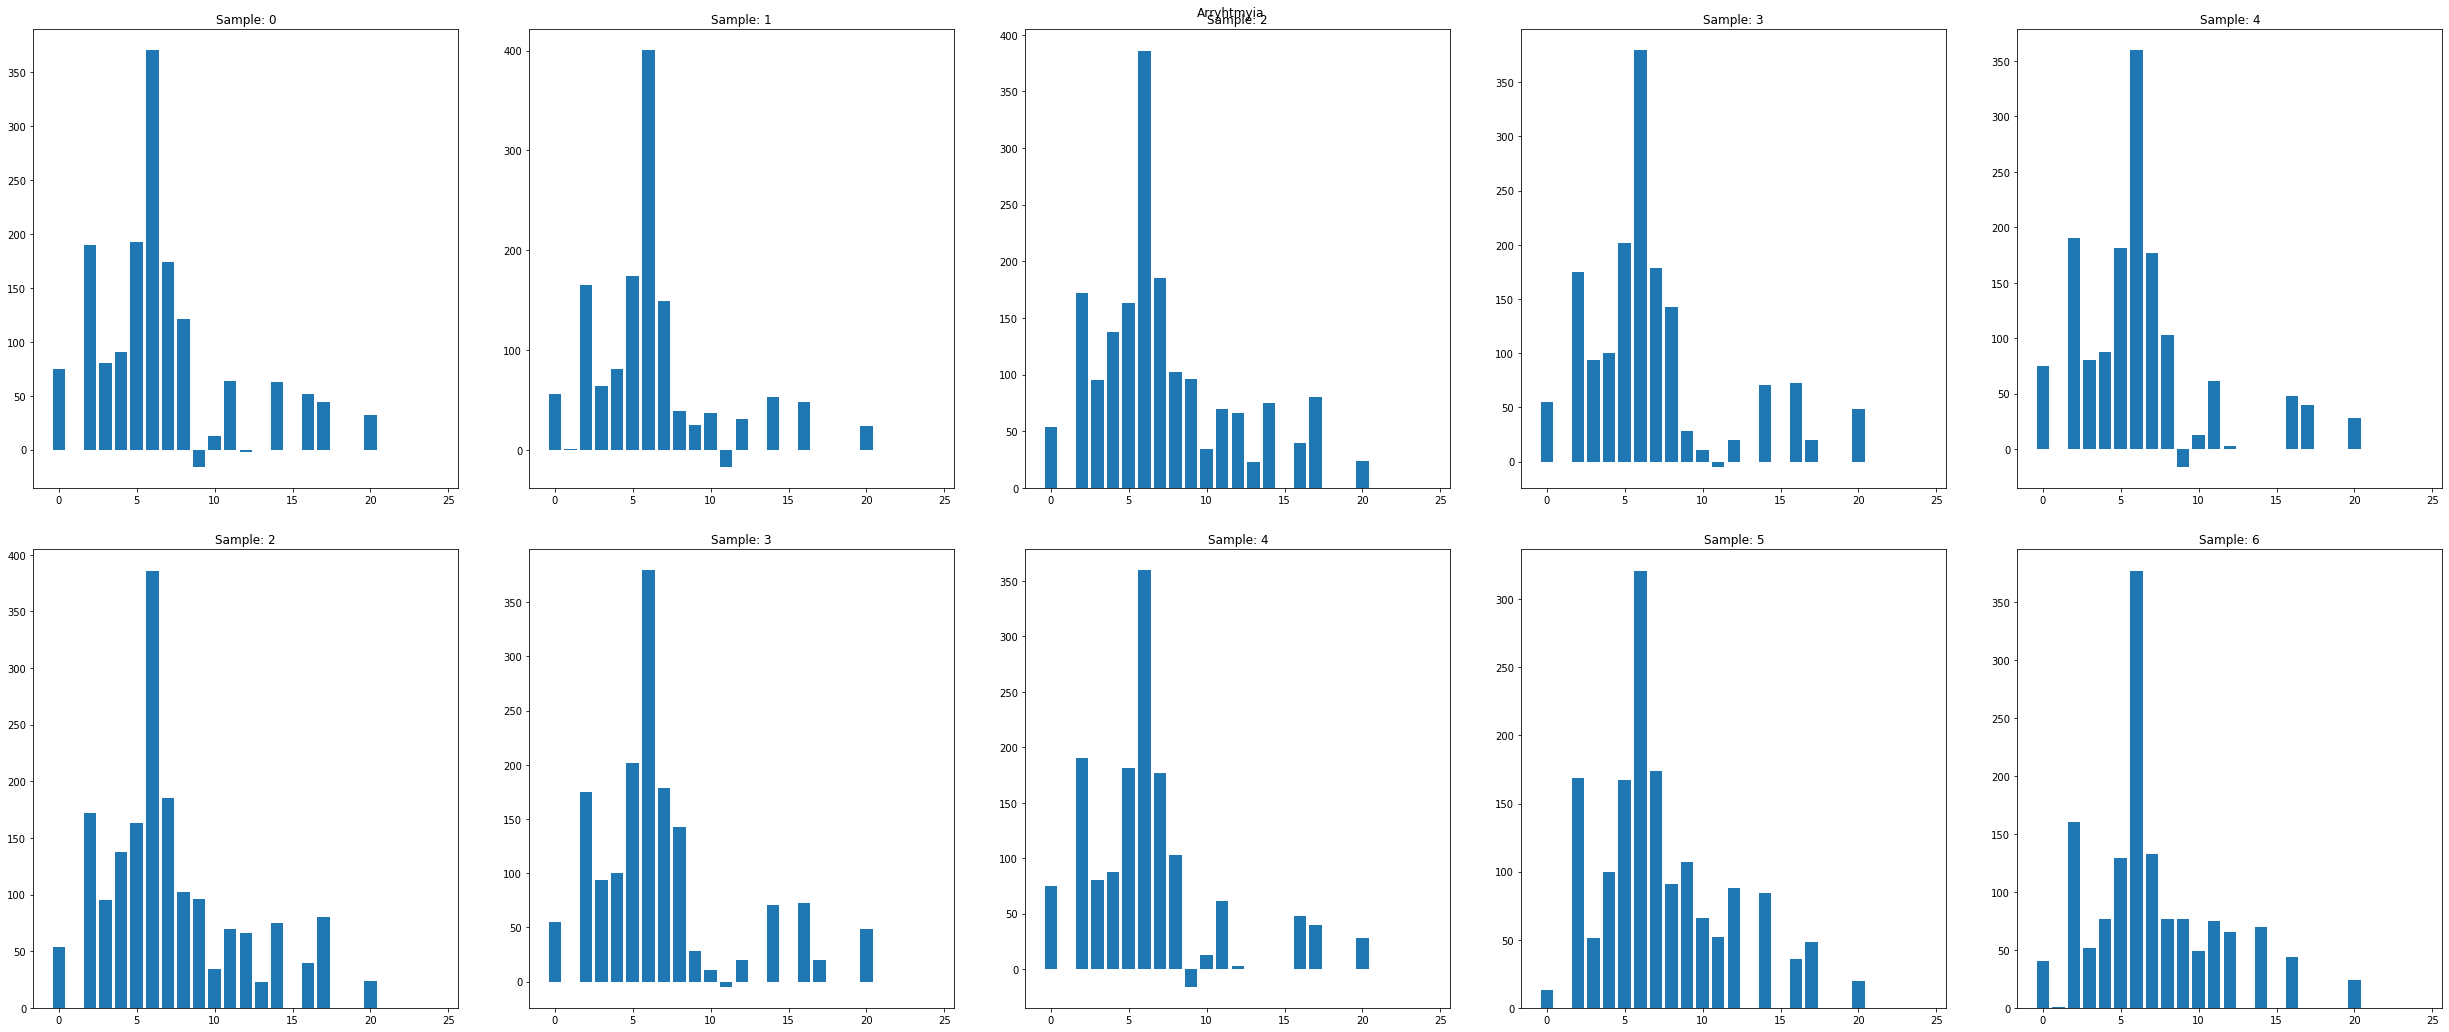

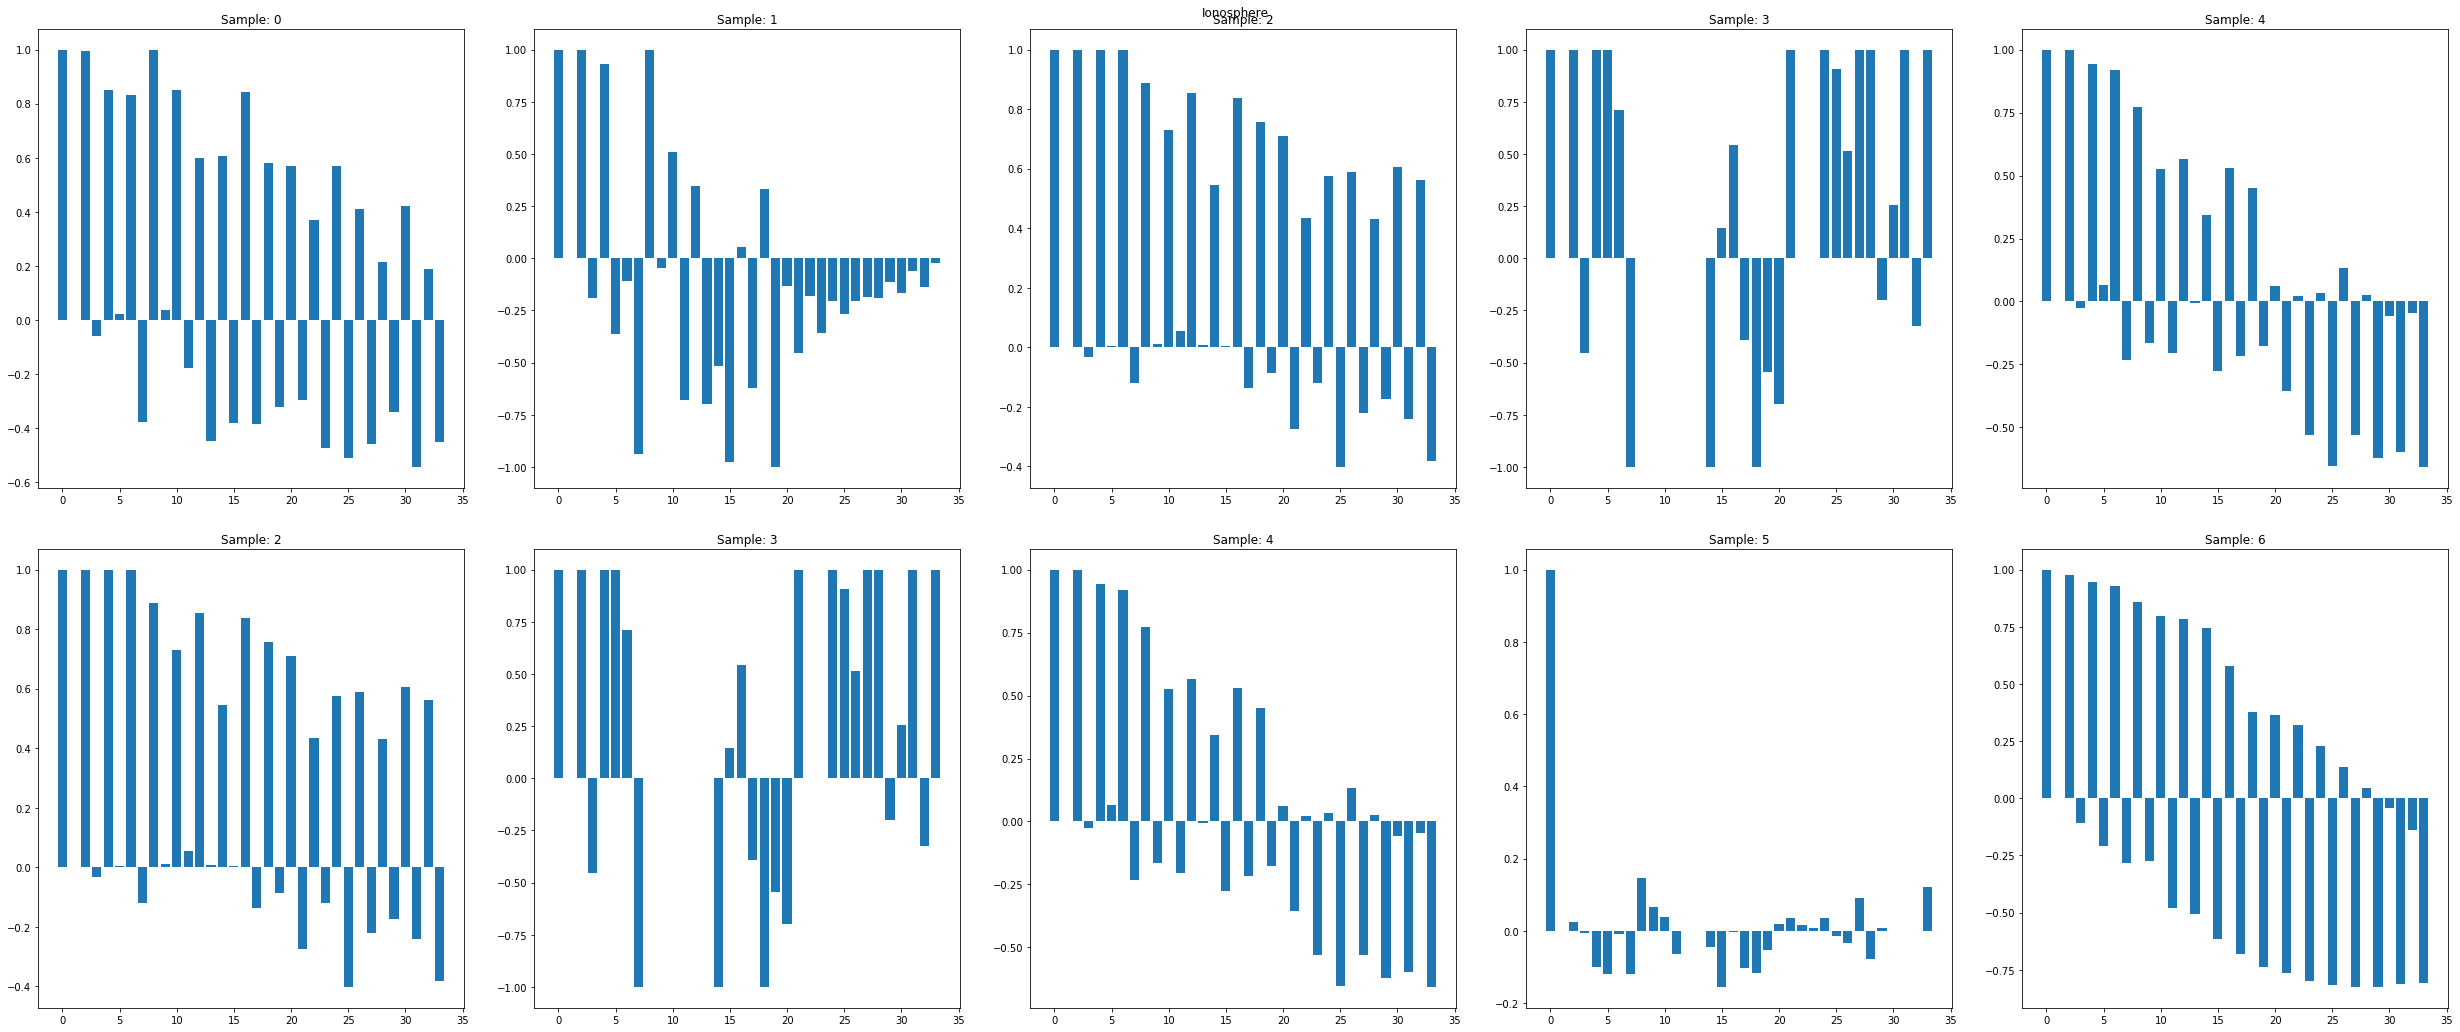

In [26]:
from sklearn.datasets import fetch_openml
X_arr, t_arr = fetch_openml('arrhythmia', version=1, return_X_y=True)
X_arr = np.nan_to_num(X_arr)[:, :25]
t_arr = np.array([1 if l == '1' else 0 for l in t_arr])

X_ion, t_ion = fetch_openml('ionosphere', version=1, return_X_y=True)
t_ion = np.array([1 if l == 'g' else 0 for l in t_ion])


# Explore the dataset
print(X_arr.shape)
print(X_ion.shape)

# Value range: Arr
min = 1000
max = -1000
for x in X_arr:
    m_min = 1000
    m_max = -1000
    for y in x:
        if y < m_min:
            m_min = y
        if y > m_max:
            m_max = y
    
    if m_min < min:
        min = m_min
    if m_max > max:
        max = m_max
print("Arr: Min: ", min, " Max: ", max)
print(X_arr.shape)

# Value range: Ion
min = 1000
max = -1000
for x in X_ion:
    m_min = 1000
    m_max = -1000
    for y in x:
        if y < m_min:
            m_min = y
        if y > m_max:
            m_max = y
    
    if m_min < min:
        min = m_min
    if m_max > max:
        max = m_max
print("Ion: Min: ", min, " Max: ", max)
print(X_ion.shape)


# Visualization of samples: Arr
fig, ax = plt.subplots(2, 5, figsize=(35, 15))
fig.tight_layout(pad=4.0)
fig.suptitle("Arryhtmyia")
for y in range(2):
    for x in range(5):
        el = X_arr[y*2 + x]
        ax[y, x].bar(range(len(el)), el)
        ax[y, x].set_title("Sample: " + str(y*2 + x))
          
          
# Visualization of samples: Ion
fig, ax = plt.subplots(2, 5, figsize=(35, 15))
fig.tight_layout(pad=4.0)
fig.suptitle("Ionosphere")
for y in range(2):
    for x in range(5):
        el = X_ion[y*2 + x]
        ax[y, x].bar(range(len(el)), el)
        ax[y, x].set_title("Sample: " + str(y*2 + x))





# Arryhtymia unprocessed
try: 
    _, error = irls(X_arr, t_arr, do_preprocessing=False)
    print("Arryhtymia unprocessed error: ", error)
    
except:
    print("Error occured during processing of Arryhtymia unprocessed.")

# Arryhtymia preprocessed
try:
    _, error = irls(X_arr, t_arr, do_preprocessing=True)
    print("Arryhtymia preprocessed error: ", error)

except:
    print("Error occured during processing of Arryhtymia unprocessed.")
    
    
    
# Ionosphere unprocessed
try: 
    _, error = irls(X_ion, t_ion, do_preprocessing=False)
    print("Ionosphere unprocessed error: ", error)
    
except:
    print("Error occured during processing of Ionosphere unprocessed.")

# Ionosphere preprocessed
try:
    _, error = irls(X_ion, t_ion, do_preprocessing=True)
    print("Ionosphere preprocessed error: ", error)

except:
    print("Error occured during processing of Ionosphere unprocessed.")

    
    
# Compare with sklearn's logistic regression

# Arryhtymia unprocessed
X, X_test, t, t_test = split_data(X_arr, t_arr, seed=1)
clf = LogisticRegression(penalty="none").fit(X, t)
print("SkLearns score on arryhtmyia (unprocessed): ", clf.score(X_test, t_test))

# Arryhtymia preprocessed
X_arr, t_arr = preprocess(X_arr, t_arr)
X, X_test, t, t_test = split_data(X_arr, t_arr, seed=1)
clf = LogisticRegression(penalty="none").fit(X, t)
print("SkLearns score on arryhtmyia (preprocessed): ", clf.score(X_test, t_test))

# Ionosphere unprocessed
X, X_test, t, t_test = split_data(X_ion, t_ion, seed=1)
clf = LogisticRegression(penalty="none").fit(X, t)
print("SkLearns score on ionosphere (unprocessed): ", clf.score(X_test, t_test))

# Ionosphere preprocessed
X_ion, t_ion = preprocess(X_ion, t_ion)
X, X_test, t, t_test = split_data(X_ion, t_ion, seed=1)
clf = LogisticRegression(penalty="none").fit(X, t)
print("SkLearns score on ionosphere (preprocessed):", clf.score(X_test, t_test))